# Biomedicina: Entrenamiento y clasificacion de datos EEG

In [1]:
import numpy as np
import pandas as pd
from pandas.tools.plotting import radviz
import matplotlib.pyplot as plt
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC

In [2]:
%matplotlib inline
plt.rcParams['figure.figsize'] = 16, 12

## Preprocesado de datos

In [3]:
s1 = '/home/cramos/Dropbox/BIO/train_subject1_raw01.asc'
s2 = '/home/cramos/Dropbox/BIO/train_subject1_raw02.asc'
s3 = '/home/cramos/Dropbox/BIO/train_subject1_raw03.asc'
t = '/home/cramos/Dropbox/BIO/test_subject1_raw04.asc'
sub1 = pd.read_fwf(s1, names=['Fp1', 'AF3', 'F7', 'F3', 'FC1', 'FC5', 'T7', 'C3', 'CP1', 'CP5', 'P7', 'P3', 'Pz', 'PO3', 'O1', 'Oz', 'O2', 'PO4', 'P4', 'P8', 'CP6', 'CP2', 'C4', 'T8', 'FC6', 'FC2', 'F4', 'F8', 'AF4', 'Fp2', 'Fz', 'Cz', 'Clase'])
sub2 = pd.read_fwf(s2, names=['Fp1', 'AF3', 'F7', 'F3', 'FC1', 'FC5', 'T7', 'C3', 'CP1', 'CP5', 'P7', 'P3', 'Pz', 'PO3', 'O1', 'Oz', 'O2', 'PO4', 'P4', 'P8', 'CP6', 'CP2', 'C4', 'T8', 'FC6', 'FC2', 'F4', 'F8', 'AF4', 'Fp2', 'Fz', 'Cz', 'Clase'])
sub3 = pd.read_fwf(s3, names=['Fp1', 'AF3', 'F7', 'F3', 'FC1', 'FC5', 'T7', 'C3', 'CP1', 'CP5', 'P7', 'P3', 'Pz', 'PO3', 'O1', 'Oz', 'O2', 'PO4', 'P4', 'P8', 'CP6', 'CP2', 'C4', 'T8', 'FC6', 'FC2', 'F4', 'F8', 'AF4', 'Fp2', 'Fz', 'Cz', 'Clase'])
tst = pd.read_fwf(t, names=['Fp1', 'AF3', 'F7', 'F3', 'FC1', 'FC5', 'T7', 'C3', 'CP1', 'CP5', 'P7', 'P3', 'Pz', 'PO3', 'O1', 'Oz', 'O2', 'PO4', 'P4', 'P8', 'CP6', 'CP2', 'C4', 'T8', 'FC6', 'FC2', 'F4', 'F8', 'AF4', 'Fp2', 'Fz', 'Cz'])

In [4]:
frames = [sub1, sub2, sub3]
subs = pd.concat(frames)

In [5]:
subs

,Fp1,AF3,F7,F3,FC1,FC5,T7,C3,CP1,CP5,...,T8,FC6,FC2,F4,F8,AF4,Fp2,Fz,Cz,Clase
0,2376.6362,-3993.0707,-292.01509,-1714.575000,-8560.3748,-12959.398,-15365.081,6104.5356,3067.4475,4910.1941,...,-7562.5642,-4529.94480,-3280.6658,-3277.9158,2412.3237,-2788.79170,5308.7558,7220.2523,11014.589,7
1,2385.5737,-3979.3833,-284.70260,-1706.606200,-8550.4998,-12953.335,-15362.925,6113.7543,3079.7912,4918.8190,...,-7562.2517,-4517.10100,-3269.2596,-3267.8221,2422.1049,-2779.47920,5306.6933,7232.2835,11026.745,7
2,2406.0424,-3954.7583,-266.32763,-1687.262500,-8529.3749,-12933.273,-15331.175,6134.6605,3101.6036,4940.0377,...,-7520.0642,-4502.25730,-3249.6971,-3246.3534,2438.0736,-2760.76050,5318.4433,7253.6585,11048.589,7
3,2435.9486,-3925.4459,-235.79644,-1659.481300,-8503.3749,-12903.054,-15292.987,6160.7542,3124.7911,4966.7252,...,-7495.2518,-4472.78860,-3224.3534,-3218.3534,2468.1986,-2730.51060,5343.7245,7280.4397,11071.714,7
4,2454.2298,-3911.9146,-219.73397,-1644.075100,-8492.0937,-12885.867,-15274.956,6173.8480,3133.7286,4979.9439,...,-7489.4080,-4458.85110,-3214.2284,-3206.5722,2480.1360,-2713.44810,5355.5370,7291.0647,11081.370,7
5,2471.3861,-3900.6959,-205.79650,-1632.075100,-8482.1875,-12873.961,-15263.175,6185.5667,3142.5723,4993.5064,...,-7473.1893,-4445.66370,-3206.2285,-3195.4472,2491.8235,-2700.54190,5367.8495,7300.7521,11089.745,7
6,2456.5736,-3913.5709,-219.35897,-1643.825100,-8494.6562,-12883.617,-15279.019,6174.9417,3131.0411,4982.7252,...,-7477.0331,-4459.41360,-3219.9472,-3208.2597,2480.9798,-2712.35440,5356.3807,7287.8772,11076.151,7
7,2430.3236,-3932.3209,-239.98393,-1661.325100,-8512.4374,-12903.429,-15297.581,6156.7230,3113.1036,4965.1002,...,-7494.5330,-4478.91360,-3237.8221,-3227.9472,2460.8861,-2733.79180,5335.0370,7269.5334,11059.151,7
8,2401.7924,-3954.7583,-265.14014,-1683.231300,-8534.3436,-12931.023,-15323.894,6132.4418,3090.4162,4938.7565,...,-7520.5330,-4501.31980,-3257.6659,-3247.0409,2438.0736,-2760.94800,5313.3183,7247.3147,11039.401,7
9,2387.1987,-3969.7583,-279.98386,-1698.481200,-8546.9373,-12945.679,-15342.706,6116.2543,3076.6974,4919.1628,...,-7536.0330,-4514.97600,-3266.9783,-3258.1659,2426.8861,-2776.13550,5301.5058,7234.6585,11029.089,7


In [6]:
subs.shape

(366592, 33)

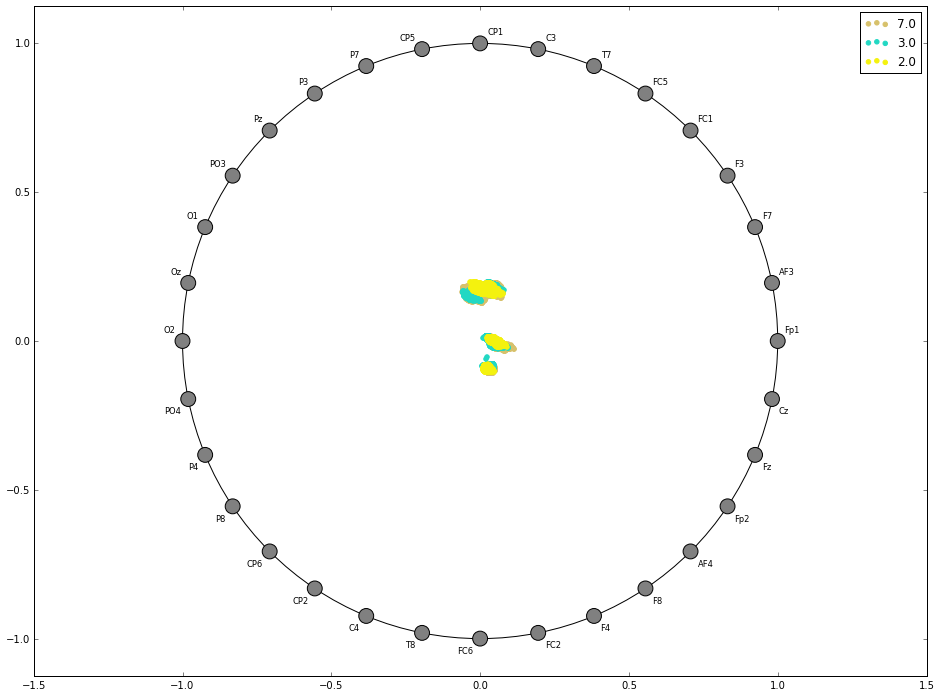

In [7]:
radviz(subs, 'Clase')

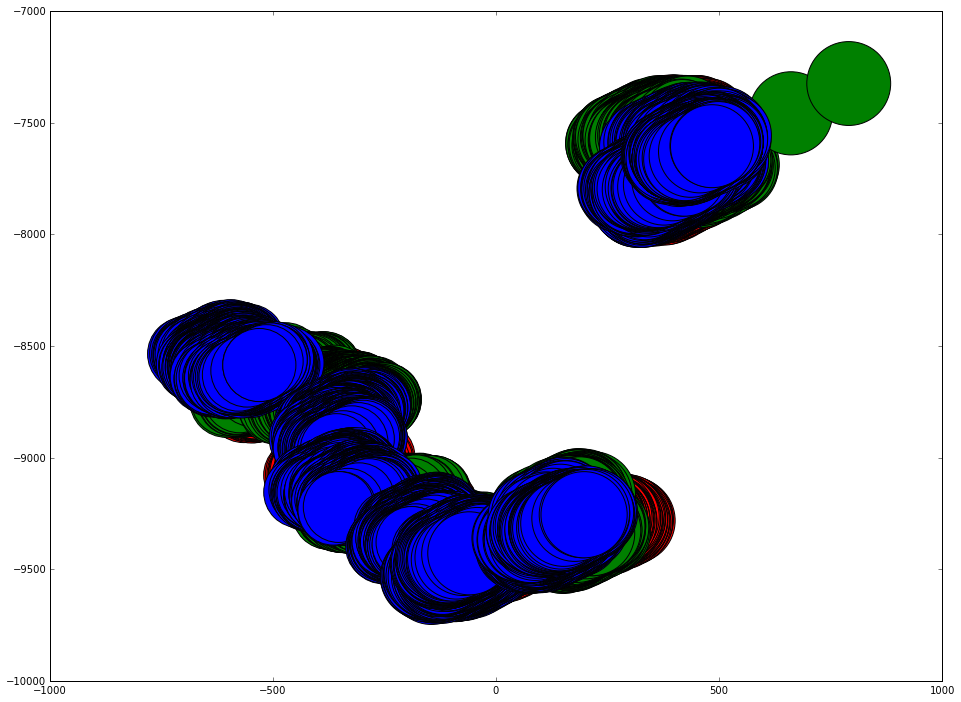

In [8]:
plt.scatter(subs[subs.Clase == 2].P3, subs[subs.Clase == 2].FC1, subs[subs.Clase == 2].Fp2, 'r')
plt.hold
plt.scatter(subs[subs.Clase == 3].P3, subs[subs.Clase == 3].FC1, subs[subs.Clase == 3].Fp2, 'g')
plt.scatter(subs[subs.Clase == 7].P3, subs[subs.Clase == 7].FC1, subs[subs.Clase == 7].Fp2, 'b')

### Construcción de matrices de entrenamiento

In [9]:
X = subs.iloc[:,0:32].values
y = subs.iloc[:,32:].values

In [10]:
Xt = tst.iloc[:,0:32].values

In [11]:
X.shape, y.shape, Xt.shape

((366592, 32), (366592, 1), (120832, 32))

## Entrenamiento

In [12]:
cla = OneVsRestClassifier(SVC(kernel='linear'), n_jobs=-1)

In [ ]:
cla_apr = cla.fit(X, y)

## Clasificación

In [ ]:
Yt = cla_apr.predict(Xt)

In [ ]:
subt = np.concatenate((Xt,Yt.T), axis=1)

In [ ]:
subt = pd.DataFrame(subt, columns=['Fp1', 'AF3', 'F7', 'F3', 'FC1', 'FC5', 'T7', 'C3', 'CP1', 'CP5', 'P7', 'P3', 'Pz', 'PO3', 'O1', 'Oz', 'O2', 'PO4', 'P4', 'P8', 'CP6', 'CP2', 'C4', 'T8', 'FC6', 'FC2', 'F4', 'F8', 'AF4', 'Fp2', 'Fz', 'Cz', 'Clase'])

In [ ]:
subt

## Ploteo de resultados

In [ ]:
radviz(subt, 'Clase')

In [ ]:
plt.scatter(subs[subs.Clase == 2].P3, subs[subs.Clase == 2].FC1, subs[subs.Clase == 2].Fp2, 'r')
plt.hold
plt.scatter(subs[subs.Clase == 3].P3, subs[subs.Clase == 3].FC1, subs[subs.Clase == 3].Fp2, 'g')
plt.scatter(subs[subs.Clase == 7].P3, subs[subs.Clase == 7].FC1, subs[subs.Clase == 7].Fp2, 'b')